Хотим узнать с каким вероятностным законом распределён рейтинг песни.

Для начала построим график

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
# from statsmodels.sandbox.regression.example_kernridge import scale

In [41]:
df = pd.read_csv('song_data.csv')
RATING = 'song_popularity'
data = df[RATING].dropna()

<Axes: ylabel='Frequency'>

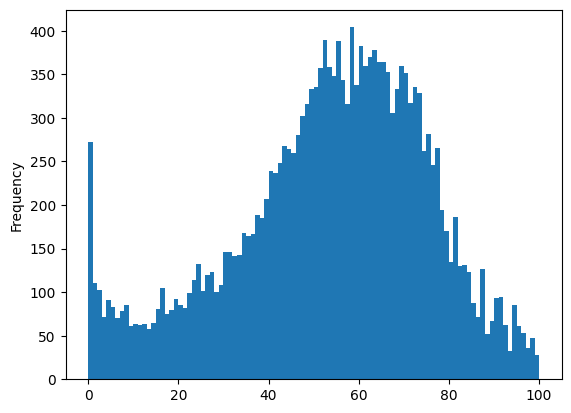

In [42]:
data.plot.hist(bins=100)

Если не учитывать песни с рейтингом 0 (что больше похоже на значние для заполнения пропусков или, что песню никто и не слушал), то можно предположть такую гипотезу:

 - $H_0: \space X \sim N(60, \sigma^2)$

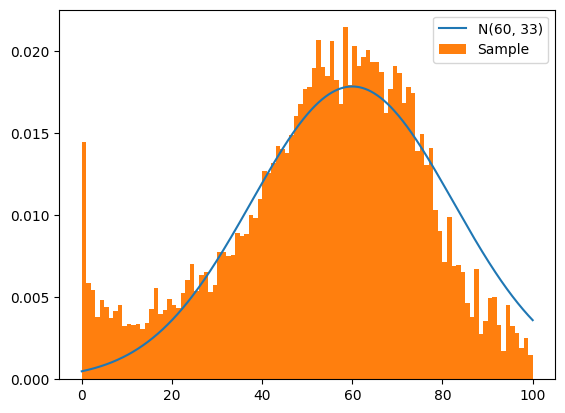

In [43]:
x = np.linspace(0, 100, 1000)

aprox_norm = stats.norm(60, np.sqrt(500))

norm = aprox_norm.pdf(x)

plt.plot(x, norm, label="N(60, 33)")
plt.hist(data, bins=100, density=True, label="Sample")
plt.legend()
plt.show()

Воспользуемся тестом Шапиро

In [44]:
from scipy.stats import shapiro
import random
# data = list(filter(lambda e : e > 0, data))

random.shuffle(data)
stat, p_value = shapiro(data[:5000])

alpha = 0.05
if p_value > alpha:
    print("Accept")
else:
    print("Reject")

Reject


Воспользуемся критерием согласия Пирсона хи-квадрат

Воспользуемся дискретной апроксимацией нормального распределения.

$p_0 = (\Phi(0), \Phi(1) - \Phi(0), \Phi(2) - \Phi(1), ... \Phi(100) - \Phi(99))$

$H_0: p = p_0$

$H_1: \space ! H_0$



In [49]:
sample_freq = [0] * 101
for e in data:
    if e is None:
        continue
    sample_freq[e] += 1
expected_freq = [0] * 101
prev = 0
for i in range(101):
    cur = aprox_norm.cdf(i)
    expected_freq[i] = round((cur - prev) * len(data))
    prev = cur
# expected_freq[100] = len(data) - sum(expected_freq)
expected_freq = expected_freq[1:]
sample_freq = sample_freq[1:]
chi2 = 0
for i in range(len(expected_freq)):
    chi2 += (sample_freq[i] - expected_freq[i])**2 / expected_freq[i]

p_value = stats.chi2.sf(chi2, df=len(expected_freq) - 1)
print("p_value: ", p_value)

alpha = 0.05

if chi2 <= stats.chi2.ppf(1 - alpha, df=len(expected_freq) - 1):
    print("Accept H_0")
else:
    print("Reject H_0")

p_value:  0.0
Reject H_0
